In [1]:
# import libraries.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import *
import graphviz

In [2]:
# define constants.
WIND_SPEED_COLUMN_NAME = 'Ws'
TORQUE_COLUMN_NAME = 'Rm'
CONVERTER_TORQUE_COLUMN_NAME = 'Cm'
ROTOR_SPEED_COLUMN_NAME = 'Rs'
POWER_COLUMN_NAME = 'P'
INPUT_COLUMNS_CLUSTERS_COUNT = 3

In [3]:
# define the feature names.
feature_names = [WIND_SPEED_COLUMN_NAME, TORQUE_COLUMN_NAME, CONVERTER_TORQUE_COLUMN_NAME, ROTOR_SPEED_COLUMN_NAME]

In [4]:
# define numpy 1D array plot function.
def plot_array(graph_title, array):
    plt.title(graph_title)
    plt.xlabel('Indices')
    plt.ylabel('Values')
    plt.plot(array, 'ob')
    plt.show()

In [5]:
# read data.
dataframe = pd.read_csv('wind_power_data_2017_2020.csv')

In [6]:
# filter the dataframe columns of wind speed, torque, converter torque, rotor speed, and power.
concat_object = [dataframe[WIND_SPEED_COLUMN_NAME],
                 dataframe[TORQUE_COLUMN_NAME],
                 dataframe[CONVERTER_TORQUE_COLUMN_NAME],
                 dataframe[ROTOR_SPEED_COLUMN_NAME],
                 dataframe[POWER_COLUMN_NAME]]
concat_keys = [WIND_SPEED_COLUMN_NAME,
               TORQUE_COLUMN_NAME,
               CONVERTER_TORQUE_COLUMN_NAME,
               ROTOR_SPEED_COLUMN_NAME,
               POWER_COLUMN_NAME]
filtered_dataframe = pd.concat(concat_object, axis=1, keys=concat_keys)

In [7]:
# fill NAs of the dataframe with 0s.
filtered_dataframe = filtered_dataframe.fillna(0)
filtered_dataframe.head()

,Ws,Rm,Cm,Rs,P
0,1.90,-336.720000,3.10,0.84,-3.080000
1,0.20,0.000000,2.40,0.14,-1.810000
2,0.18,-18.889999,2.39,0.33,-1.890000
3,4.91,1571.050000,1802.37,11.52,199.350010
4,4.20,877.039980,1171.28,9.58,92.589996


In [8]:
# define the power categories names.
power_categories_names = np.array(['negative infinity ~ -1', '0 ~ 499', '500 ~ 999', '1000 ~ 1299', '1300 ~ 1599', '1600 ~ 1899', '1900 ~ positive infinity'])

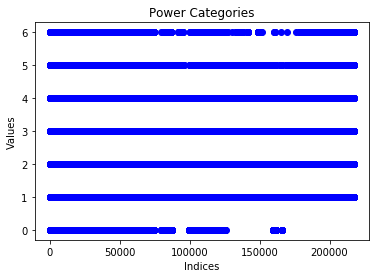

In [9]:
# categorize the power column.
bins = np.array([np.NINF, 0, 500, 1000, 1300, 1600, 1900, np.Inf])
powers = filtered_dataframe[POWER_COLUMN_NAME].to_numpy()
power_category_indices = np.digitize(powers, bins, right=False)
power_categories = power_category_indices - 1
plot_array('Power Categories', power_categories)

In [10]:
# generate the output dataframe.
output_categorical = pd.Categorical.from_codes(power_categories, power_categories_names)
output_dataframe = pd.get_dummies(output_categorical)
output_dataframe.head()

,negative infinity ~ -1,0 ~ 499,500 ~ 999,1000 ~ 1299,1300 ~ 1599,1600 ~ 1899,1900 ~ positive infinity
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [11]:
# generate the input dataframe by filtering out the power column from the filtered dataframe.
concat_object = [filtered_dataframe[WIND_SPEED_COLUMN_NAME],
                 filtered_dataframe[TORQUE_COLUMN_NAME],
                 filtered_dataframe[CONVERTER_TORQUE_COLUMN_NAME],
                 filtered_dataframe[ROTOR_SPEED_COLUMN_NAME]]
concat_keys = feature_names
input_dataframe = pd.concat(concat_object, axis=1, keys=concat_keys)
input_dataframe.head()

,Ws,Rm,Cm,Rs
0,1.90,-336.720000,3.10,0.84
1,0.20,0.000000,2.40,0.14
2,0.18,-18.889999,2.39,0.33
3,4.91,1571.050000,1802.37,11.52
4,4.20,877.039980,1171.28,9.58


In [12]:
# define array clustering function.
def get_clutered_array(array, cluters_count):
    kmeans = sk.cluster.KMeans(n_clusters=cluters_count, random_state=0).fit(array.reshape(-1,1))
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_[:, 0]
    result = np.copy(array)
    for index in range(len(array)):
        result[index] = centroids[labels[index]]
    return result

In [13]:
# define dataframe column clustering function.
def get_column_clustered_dataframe(dataframe, clusters_count):
    result = dataframe.copy()
    for column_name in dataframe:
        column_array = dataframe[column_name].to_numpy()
        clustered_array = get_clutered_array(column_array, clusters_count)
        result[column_name] = pd.Series(clustered_array)
    return result

In [14]:
# cluster the input dataframe by column.
input_dataframe = get_column_clustered_dataframe(input_dataframe, INPUT_COLUMNS_CLUSTERS_COUNT)
input_dataframe.head()

,Ws,Rm,Cm,Rs
0,2.034018,518.936949,647.535829,0.692551
1,2.034018,518.936949,647.535829,0.692551
2,2.034018,518.936949,647.535829,0.692551
3,5.679680,518.936949,647.535829,10.598060
4,5.679680,518.936949,647.535829,10.598060


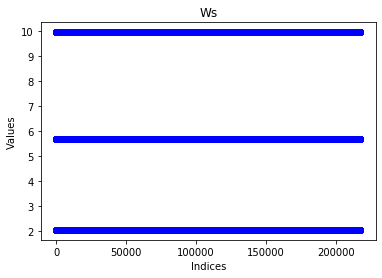

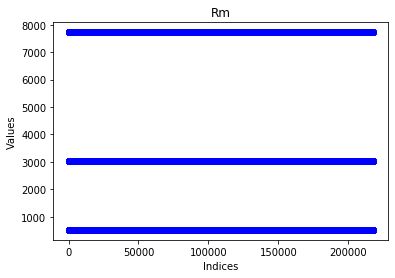

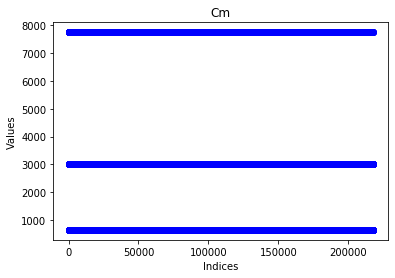

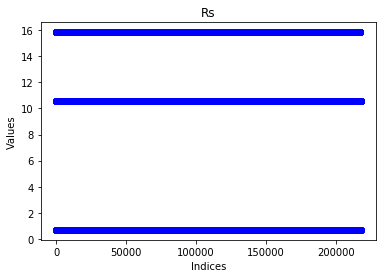

In [15]:
# plot all columns of the clustered input dataframe.
for column_name in input_dataframe:
    plot_array(column_name, input_dataframe[column_name].to_numpy())

In [16]:
# define functions for transferring pandas dataframe to sklearn array.
def get_sk_decision_tree_input(dataframe):
    return dataframe.to_numpy()

def get_sk_decision_tree_output(dataframe):
    return np.array(dataframe).argmax(axis=1)

In [17]:
# split input and output dataframes into random train and test subsets.
TEST_SIZE = 0.25
train_input_dataframe, test_input_dataframe, train_output_dataframe, test_output_dataframe = sk.model_selection.train_test_split(input_dataframe, output_dataframe,
                                                                                                                                 test_size=TEST_SIZE,
                                                                                                                                 random_state=1)
train_input_array = get_sk_decision_tree_input(train_input_dataframe)
test_input_array = get_sk_decision_tree_input(test_input_dataframe)
train_output_array = get_sk_decision_tree_output(train_output_dataframe)
test_output_array = get_sk_decision_tree_output(test_output_dataframe)

In [18]:
# generate the decision tree classifier.
decision_tree_classifier = sk.tree.DecisionTreeClassifier()
decision_tree = decision_tree_classifier.fit(train_input_array, train_output_array)

In [19]:
# output pdf of the decision tree.
OUTPUT_FILE_NAME = 'Wind Power Decision Tree'
graphviz_dot = sk.tree.export_graphviz(decision_tree, out_file=None, feature_names=feature_names)
graph = graphviz.Source(graphviz_dot)
graph.render(OUTPUT_FILE_NAME)

'Wind Power Decision Tree.pdf'

In [20]:
# predict using the decision tree classifier.
predicted_output_array = decision_tree_classifier.predict(test_input_array)

# output the decision tree classifier accuracy score.
sk.metrics.accuracy_score(test_output_array, predicted_output_array)

0.7544533705902899